In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
electricity = pd.read_csv('./Electric_Production.csv')

In [3]:
df = pd.DataFrame()
df['date'] = pd.to_datetime(electricity['DATE'], format='%m/%d/%Y')
df['electricity'] = electricity['IPG2211A2N']
df

,date,electricity
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [5]:
df = df.set_index('date')

In [6]:
df = df.asfreq('MS')

In [7]:
df = df.sort_index()
df.head()

,electricity
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [8]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [9]:
# Verify that a temporary index is complete
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),
                             end=df.index.max(),
                             freq=df.index.freq)).all()

True

In [10]:
train = df[:300]
test  = df[300:]

In [11]:
print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates : 1985-01-01 00:00:00 --- 2009-12-01 00:00:00  (n=300)
Test dates  : 2010-01-01 00:00:00 --- 2018-01-01 00:00:00  (n=97)


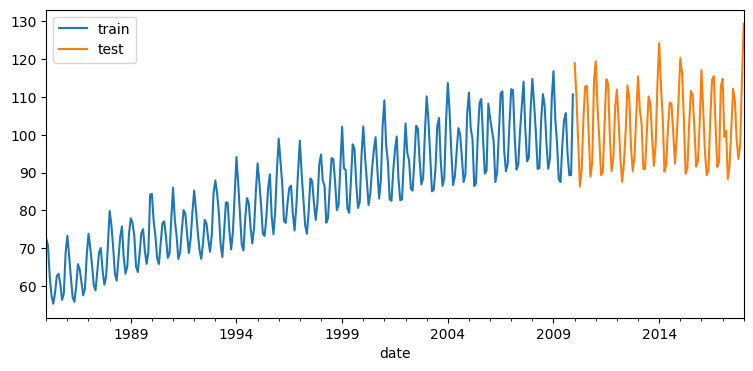

In [12]:
fig, ax=plt.subplots(figsize=(9, 4))
train['electricity'].plot(ax=ax, label='train')
test['electricity'].plot(ax=ax, label='test')
ax.legend();

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [15]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=train['electricity'])
forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1985-01-01 00:00:00'), Timestamp('2009-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 123, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-06 11:30:55 
Last fit date: 2022-12-06 11:30:55 
Skforecast version: 0.5.1 
Python v

In [18]:
# Predictions
# ==============================================================================
steps = test.__len__()
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2010-01-01    110.052363
2010-02-01    103.181455
2010-03-01     95.123481
2010-04-01     88.435122
2010-05-01     90.673007
Freq: MS, Name: pred, dtype: float64

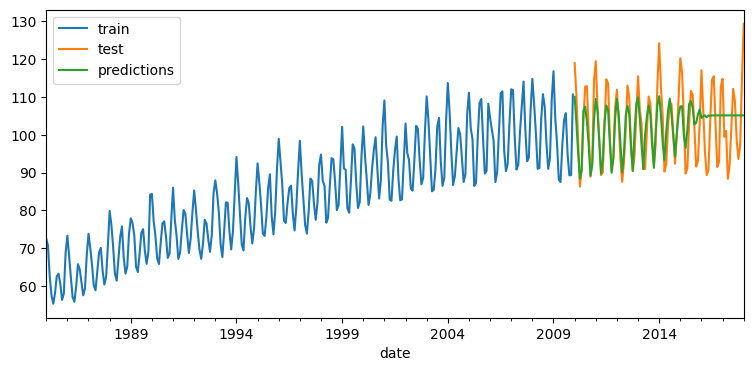

In [19]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['electricity'].plot(ax=ax, label='train')
test['electricity'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [21]:
from sklearn.metrics import mean_squared_error
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['electricity'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 52.194051140291855


In [22]:
from skforecast.model_selection import grid_search_forecaster
# Hyperparameter Grid search
# ==============================================================================
steps = test.__len__()
forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['electricity'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:07<00:00,  3.72s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 41.53364072149034



In [23]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",41.533641,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",43.149666,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",56.118190,5,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",57.001708,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",57.003938,10,100


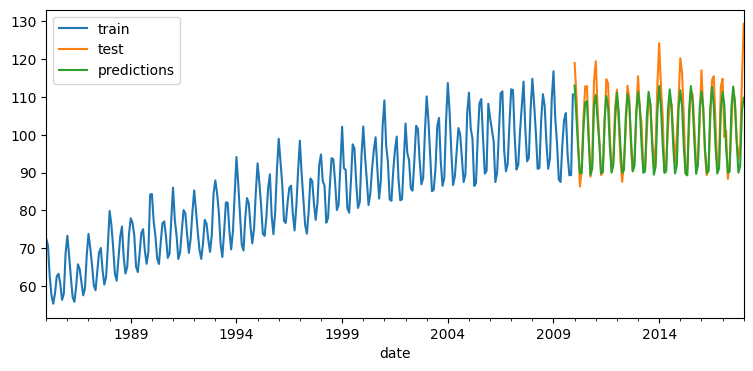

In [24]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
train['electricity'].plot(ax=ax, label='train')
test['electricity'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

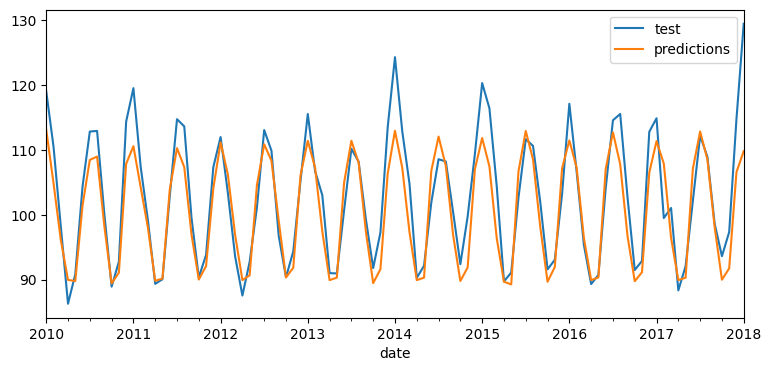

In [25]:
fig, ax=plt.subplots(figsize=(9, 4))
test['electricity'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();